<a href="https://colab.research.google.com/github/NicolasManuelKoch/cap-comp215/blob/main/Take_Home_Exam_Nicolas_Manuel_Koch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Nicolas Manuel Koch, **Credit:** based on code from ch. 11 Agent-Based Models in Think Complexity, 2nd edition. Copyright 2016 Allen Downey, MIT License

**Date:** 2023/04/17

**Purpose:** To explore how we can us Sugarscape to visualize and understand simple economical concepts. For this notebook specifically, we want to find out how an extreme capitalist system (where people have to find food and can't rely on "community") and an extreme socialist system (where people are garantueed food, so that people never starve to death) differ over the long term.

# **Sugarscape**

**About the model**

The Sugarscape model is like a virtual game that simulates how people might interact in a society where they need to find and consume sugar to survive. It's similar to a computerized board game where people, so called "agents", move around on a grid and look for patches of land with sugar on them.

In this virtual world, agents have different abilities, like how far they can see and how fast they can move. They also have to eat sugar to stay alive, just like we need food in the real world. So they move around on the grid, searching for patches of land with sugar, and when they find some, they eat it to replenish their energy.

Each patch of land can only provide a limited amount of sugar before it runs out, so the sugar doesn't last forever. Agents also age and might die if they can't find enough sugar to eat. Some agents might even have babies and create new agents to replace them when they pass away.

The agents in the game have rules for how they move and make decisions. For example, they might move towards patches of land with more sugar or avoid areas with too many other agents. They can also trade sugar with each other or move to different parts of the grid to find more sugar.

Scientists use the Sugarscape model to study how different factors, like the availability of sugar and the speed of agent movement, affect the behavior of the agents and the overall dynamics of the society. It helps them understand how complex phenomena, such as wealth inequality, migration, and social policies, might arise from simple rules that govern how individual agents behave in their environment.

First, we import all the relevant libraries.

In [14]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py

!pip install empiricaldist

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import chain

from Cell2D import Cell2D, draw_array
from utils import decorate, three_frame
from empiricaldist import Cdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next, we define a class called **"Agent"**, in which we set up all the *parameters* and *attributes* belonging to the agents in our sugarscape environment.
For our purposes, the agent is defined as having the properties: **vision, metabolism, lifespan** and a **initial sugar range**. Other models could include more (or less) properties than that, but we will keep our model simple as this should only serve to demonstrate how sugarscape works.

Included in that class are functions that define a list of agents at a random location in the grid, a list that contains coordinates that are visible to the agent (ordered by distance to agent), a cell location (that is visible to the agent) with the most sugar, a step function that makes the agent look around, harvest and move (essentially a combination of our functions), as well as functions that check if sugar has gone negative and if the lifespan of an agent is exceedeed.

In [15]:
class Agent:
    max_vision=6
    max_metabolism=4
    lifespan_range=(100, 300)
    initial_sugar_range=(5, 25)

    def __init__(self, loc=(0,0), vision=None, metabolism=None, lifespan=None, sugar=None):
        """Creates a new agent at the given location.
        
        loc: (x,y) tuple coordinate
        params: define agent's attributes - by default these are drawn from uniform distributions defined by class variables
        """
        self.loc = tuple(loc)
        self.age = 0

        # set attributes or draw from uniform distributions defined by class
        self.vision = vision or np.random.randint(1, self.max_vision+1)
        self.metabolism = metabolism or np.random.uniform(1, self.max_metabolism)
        self.lifespan = lifespan or np.random.uniform(*self.lifespan_range)
        self.sugar = sugar or np.random.uniform(*self.initial_sugar_range)

    @classmethod
    def make_agents(cls, num_agents, n, m):
        """ Factory: return a list Agent objects at random locations in n x m grid """
        # all (x,y) locations in an n x m grid...
        locations = make_locations(n, m)
        assert num_agents <= len(locations)  # verify pre-condition: there are enough locations for all agents
        # randomize the locations and construct the desired number of agents at random locations
        np.random.shuffle(locations)
        return [cls(locations[i]) for i in range(num_agents)]

    def visible_locations(self):
        """Return a list of (x,y) cell coordinates that are "visible" to this agent, ordered by distance from agent """
        def cardinal_neighbours(x, y, dist):
            """ A randomly ordered list of cardinal cells at the given distance from given (x,y) location."""
            a = [(x-dist, y), (x+dist, y), (x, y-dist), (x, y+dist)]
            np.random.shuffle(a)
            return a

        arrays = (cardinal_neighbours(*self.loc, distance) for distance in range(1, self.vision+1))
        return list(chain(*arrays))  # chain creates a single iterable from all the cardinal neighbours lists

    def find_highest_value_cell(self, env):
        """Finds the visible cell with the most sugar within this agent's vision.

        env: the Sugarscape environment this agent lives in
        returns: tuple, coordinates of highest value cell
        """
        # find all empty, visible cells, "wrapping" vision around edges of environment
        visible_locs = env.wrap_locations( self.visible_locations() )
        empty_locs = env.get_empty_locations(visible_locs)

        # return the cell with the highest sugar content from empty, visible cells...
        if len(empty_locs) > 0:
            i = np.argmax(env.get_sugar(empty_locs)) # (in case of tie, argmax returns the first, which is the closest)
            return empty_locs[i]
        else:  # there are no empty visible cells, so only choice is to stay put
            return self.loc

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = self.find_highest_value_cell(env)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

Now, we define a function, that returns a location in a n x m grid.

In [16]:
def make_locations(n, m):
    """ Return list of (x, y) coordinates for all locations on n x m grid """
    return [(i, j) for i in range(n) for j in range(m)]

In order to properly use our future Sugarscape class, we'll need to define certain functions. We need a function that defines the landscape with fixed sugar capacity of each cell as a nxn grid (based on distance of cell to two peaks), a function that returns the distance from input coordinates (to be able to set the capacity of sugar for each cell), and lastly a function that returns the capacity array.

In [17]:

def make_capacity_landscape(n):
    """ Return nxn array with fixed "capacity" for each cell."""
    # for the classic model, the landscape has 2 mounds of high-capacity sugar growing
    # compute the distance of each cell from these 2 peaks.
    lower_left = int(.3 * n)
    dist1 = distances_from(n, lower_left, lower_left)
    upper_right = int(.6 * n)
    dist2 = distances_from(n, upper_right, upper_right)
    dist = np.minimum(dist1, dist2)

    return get_capacity(dist)  # capacity is inversely proportional to distance from the 2 "peaks"

def distances_from(n, i, j):
    """Computes an n x n 2D array of distances from coordinate (i, j)

    n: size of the array
    i, j: coordinates to find distance from

    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

def get_capacity(distance_to_peak, contours=(21, 16, 11, 6)):
    """ return array of capacities, inversely related to distances, digitized by the distance contours

    distance_to_peak: 2D array of distances to nearest "peak"

    contours: a list of distances that form contours with increasing capacity in each contour
    """
    return np.digitize(distance_to_peak, contours)

In the next step, we create an instance of our **"Agent"** class with 200 agents  that are placed in a random location in a 40 x 40 grid, with visibility of less than 7, as defined (max_vision) in our Agent class.

In [18]:
n = 50
agents = Agent.make_agents(200, n, n)  # create 200 agents at random locations in n x m grid

# **Sugarscape class**

Our **Sugarscape** class involves a 2D grid that represents the landscape of  sugar, which the agents move around on and consume.

The Sugarscape is implemented as a Cell2D class with four core attributes:



*   array: an array of cells, each containing a quantity of sugar.
*   growth_rate: the rate at which sugar replenishes in each cell.
*   capacity: an array that specifies the maximum capacity of each cell, limiting the amount of sugar that can be stored.
*   agents: a list of Agent objects that inhabit the Sugarscape.

The behavior of the Sugarscape simulation is straightforward:

Time Step: At each time step, agents have the opportunity to take actions in the Sugarscape.

Sugar Growth: If a cell's sugar level is below its capacity, agents can grow some sugar in that cell.

Globe-like Wrapping: The Sugarscape is treated as a globe, with coordinates wrapping around the top-bottom and left-right edges, providing seamless navigation.

Migration: Agents can search for empty locations in the Sugarscape where they might migrate to, in search of better resources.

Sugar Harvesting: Agents can "see" the amount of sugar in any location in the Sugarscape and harvest that sugar for their consumption.


Overall, the behavior of the Sugarscape simulation involves agents taking steps, growing sugar, navigating the globe-like Sugarscape, migrating to empty locations, and harvesting sugar to sustain themselves.

In [19]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, agents, grow_rate=1, replace_agents=False):
        """Initializes the attributes.

        n: number of rows and columns
        agents: iterable of agents, with random locations on (n, n)
        replace_agents: Agent model to use to replace dead agents with, or False for no replacement
        grow_rate: sugar re-growth rate
        """
        assert(len(agents) <= n**2)  # can't have more agents than there are grid cells

        self.n = n
        self.agents = agents
        self.grow_rate = grow_rate
        self.replace_agents = replace_agents

        # make the capacity array  (constant - capacity never changes - represents upper bound)
        self.capacity = make_capacity_landscape(n)
        # initially all cells are at capacity, this array is the dynamic state of sugar at each loc
        self.array = self.capacity.copy()

        # keep track of which cells are unoccupied
        self.unoccupied = set(make_locations(n, n)) - set(agent.loc for agent in self.agents)

        # tracking variables
        self.agent_count_seq = []

    def wrap_locations(self, locations):
        """ return listt of (x,y) locations, where each location is "wrapped" so it falls within the sugarscape grid

        locations: iterable of 2-tuple (x,y) locations, some of which may fall outside grid dimensions
        """
        return [(x%self.n, y%self.n) for x,y in locations]

    def get_empty_locations(self, locations):
        """ select and return list locations that are unoccupied """
        return [loc for loc in locations if loc in self.unoccupied]

    def get_sugar(self, locations):
        """ return list of sugar level at each location """
        return [self.array[loc] for loc in locations]

    def grow(self):
        """ add sugar to all cells and caps them by capacity."""
        self.array = np.minimum(self.array + self.grow_rate, self.capacity)

    def harvest(self, loc):
        """ remove and return the sugar from (x, y) `loc` """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        """ Execute one time step. """
        # loop through the agents in random order
        for agent in np.random.permutation(self.agents):
            # mark the agent's cell unoccupied and allow them to "step" to new location
            self.unoccupied.add(agent.loc)
            agent.step(self)

            # if the agent is dead, remove from model and potential replace with new agent
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if self.replace_agents:
                    self.add_agent(AgentModel=self.replace_agents)
            else:
                # otherwise mark its new cell as occupied
                self.unoccupied.remove(agent.loc)

        # update the time series tracking data
        self.agent_count_seq.append(len(self.agents))

        # grow back some sugar
        self.grow()
        return len(self.agents)

    def add_agent(self, AgentModel):
        """ return a new agent at a random, unoccuped location """
        new_agent = AgentModel( loc=random.sample(self.unoccupied, k=1)[0] )
        self.agents.append(new_agent)
        self.unoccupied.remove(new_agent.loc)
        return new_agent

    def draw(self):
        """Draws the Sugarscape with its agents """
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        if self.agents:
            self._draw_agents()

    def _draw_agents(self):
        """ Draw the agents in centre of cell they occupy """
        # Transform from (col, row) to centre (x, y) of cell coordinate.
        rows, cols = np.transpose([agent.loc for agent in self.agents])
        xs = cols + 0.5
        ys = rows + 0.5
        plt.plot(xs, ys, '.', color='red')

Now, remember when we created the an instance of our **Agent** class? We will now use these **"agents"** and our amount of cells **n** to set them up in our new **Sugarscape** landscape. For this to happen we will need to create an instance of our Sugarscape class. We then plot the agents on our new landscape that we have defined in Sugarscape by using the imported three_frame() function at 0, 5 and 100 timesteps. This makes it possible to see how our agents move during these timesteps and how many die by starvation. Agents are defined to only die of age after 100 timesteps, so this is not a factor in our visualization.

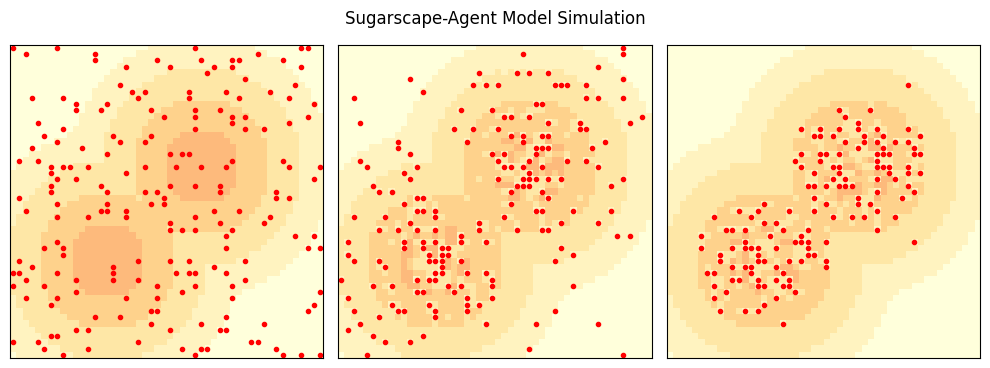

In [20]:
Test_agents_in_sugarscape = Sugarscape(n, agents)

three_frame(Test_agents_in_sugarscape, [0, 5, 100])
plt.suptitle("Sugarscape-Agent Model Simulation")  

plt.show()

To see how many agents are still alive after 100 timesteps, we will plot the number of agents alive.

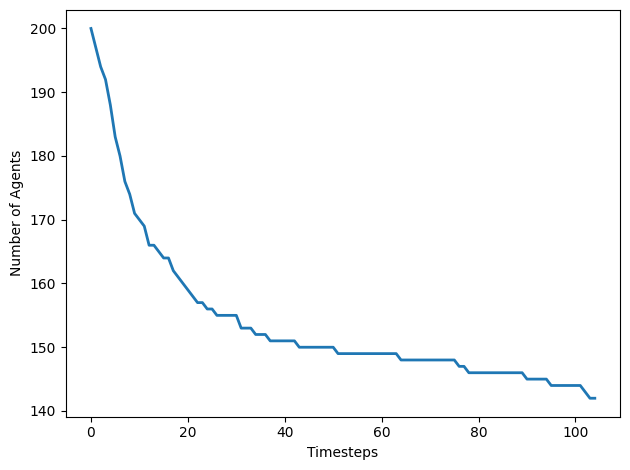

In [21]:
plt.plot(Test_agents_in_sugarscape.agent_count_seq)
decorate(xlabel='Timesteps', ylabel='Number of Agents')

As we can see in the images above, the **red** points are our **agents**, randomly spread across our grid, while our sugarscape environment is highlighted by the **two redish peaks** in the middle of the image, getting lighter (less sugar) the bigger the distance to the peaks.

Over the span of **100 timesteps**, the amount of agents **decreases** from our initial 200 to less than 150, purely because the rest of the agents couldn't find sugar soon enough and starved (lifespan is 100 timesteps minimum). This itself is a wonderful demonstration of the capitalist system, where the smarter, physiological better built person and the one with better starting "capital" wins over unluckier candidates over the longterm. In a socialist system where every person was garantueed shelter and food, this couldn't happen as people wouldn't be dependent on their genetics or in our case the ability to find "sugar". From a philosophical standpoint and for the evolution of human beings, which system is implemented has tremendous consequences. In a highly capitalistic system, we can assume that the human race will continue to get stronger, more intelligent and in general more resistant (as only these people will survive). However, we have to ask ourselves if that is what we as human beings need and want. We are at a point where we have awareness of these things and can actually take active control over these decisions. Does humanity still need to get smarter and "stronger". If yes, what for if the goal isn't to make life more livable, by making it easier and more enjoyable?

# **Experiment: Extreme Socialist vs Extreme Capitalist System**

In the following few code snippets, we are going to change the Agent class, so as to show (albeit in a very simple form) what happens in a extreme capitalist system where people need to look for food vs an extreme socialst system where they are garantueed food and don't ever need to hunger. To do this we assume human beings to have an average life expectancy of 60 -100, but each agent reproduces on average once in their lifetime. For the capitalistic system, agents have a maximal metabolism rate of 4, so they need to find sugar themselves, otherwise they are going to die. For the socialistic system, agents don't need to hunger so we set the max  metabolism to 0, so they will never have to find sugar in order to survive. In both systems, the agents will be provided with one extra sugar per timestep.

In [22]:
class Mortal_Reproducing(Agent):
    """ The lifespan is given between 60 to 100, with a max metabolsim rate of 4. """
    max_metabolism=4
    lifespan_range=(60, 100)
    """we give each agent 1 sugar each timestep and make them have "children" on average once during their lifetime"""
    def step(self, env):
        self.loc = self.find_highest_value_cell(env)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1
        self.sugar += 1
        if self.age == random.randint(40, 60):  # add new agent if random number is equal to age
            new_agents = Mortal_Reproducing.make_agents(1, 50, 50) #make a new agent on a random position in the grid
            env.agents.append(new_agents[0]) #add agent to the other agents


In [23]:
class NoSugarNeeded_M_R(Agent):
    """ The lifespan is given between 60 to 100, with a max metabolsim rate of 0, so the agent never starves to death. """
    max_metabolism=0
    lifespan_range=(60, 100)
    """we give each agent 1 sugar each timestep and make them have "children" on average once during their lifetime"""
    def step(self, env):
        self.loc = self.find_highest_value_cell(env)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1
        self.sugar += 1
        if self.age == random.randint(40, 60):  # add new agent if random number is equal to age
            new_agents = NoSugarNeeded_M_R.make_agents(1, 50, 50)#make a new agent on a random position in the grid
            env.agents.append(new_agents[0])#add agent to the other agents

We now create an instance for both systems and visualize the number of agents "alive" for both systems at the beginning, after 5 timesteps and after 10000 timesteps.

First, we do it for our capitalist system.

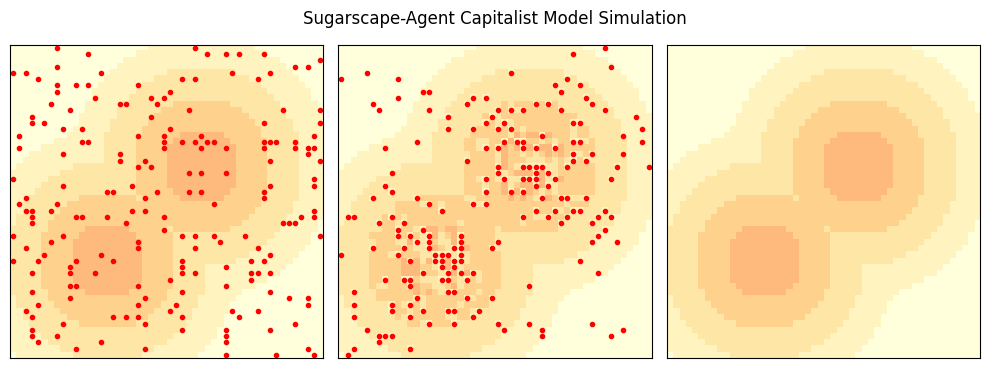

In [24]:

n = 50
mortal_reproducing_agents = Mortal_Reproducing.make_agents(200, n, n) #create 200 mortal agents on a 50x50 grid

Test_mortal_reproducing_agents = Sugarscape(n, mortal_reproducing_agents) #place the agents on our sugarscape landscape

three_frame(Test_mortal_reproducing_agents, [0, 5, 10000]) #visualize the agents on the sugarscape landscape at frame 0, 5 and 100
plt.suptitle("Sugarscape-Agent Capitalist Model Simulation")  #add title to our visualization

plt.show() 

Now, we do it for our socialist system.

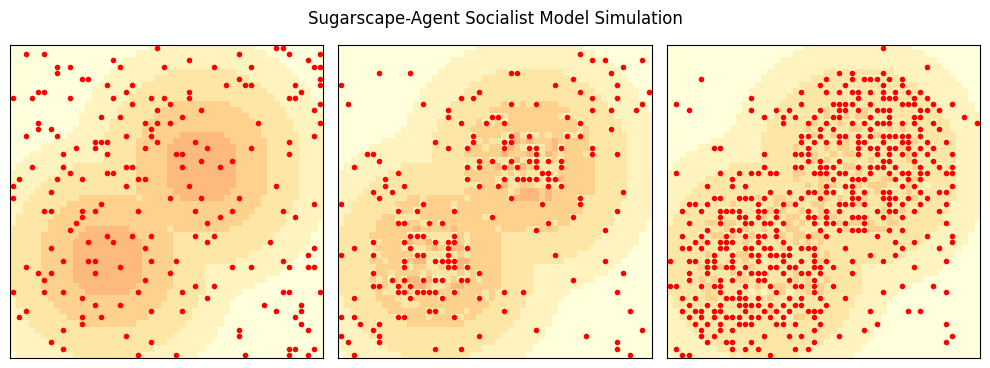

In [25]:
n = 50
Socialist_agents = NoSugarNeeded_M_R.make_agents(200, n, n) #create 200 mortal agents, that don't have to hunger on a 50x50 grid

Test_socialist_system = Sugarscape(n, Socialist_agents) #place the agents on our sugarscape landscape

two = three_frame(Test_socialist_system, [0, 5, 10000]) #visualize the agents on the sugarscape landscape at frame 0, 5 and 100
plt.suptitle("Sugarscape-Agent Socialist Model Simulation")   #add title to our visualization

plt.show()

To better illustrate our results and understand the differences, we will plot the results next to each other.

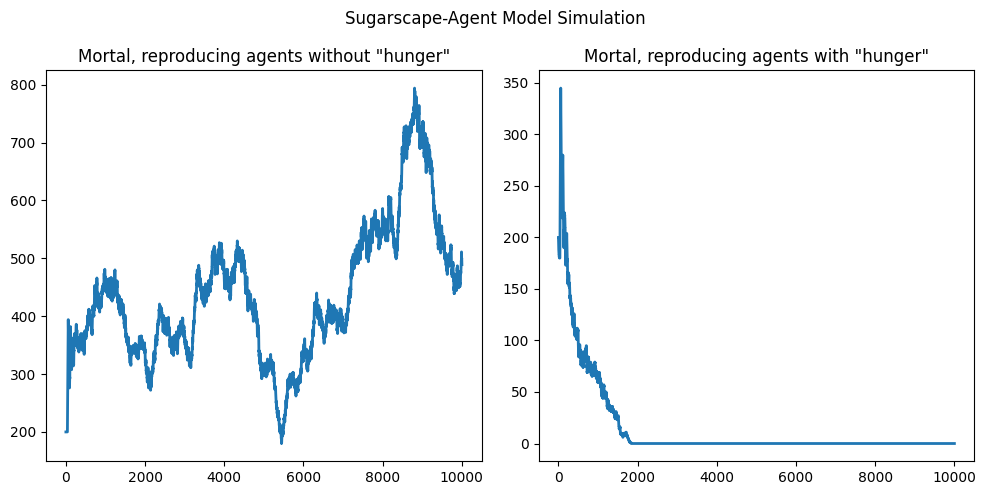

In [26]:

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot socialist system
axs[0].plot(Test_socialist_system.agent_count_seq)
axs[0].set_title('Mortal, reproducing agents without "hunger"')

# Plot capitalist system
axs[1].plot(Test_mortal_reproducing_agents.agent_count_seq)
axs[1].set_title('Mortal, reproducing agents with "hunger"')

# Set overall title for the subplot
fig.suptitle('Sugarscape-Agent Model Simulation')

# Set layout
plt.tight_layout()

# Show the plot
plt.show()

As we can see, agents are normally still **"alive"** in the socialist system after 10000 timesteps, while in the capitalist system agents are all usually **"dead"** by timestep 2000. This shows that even though, in the capitalist system, human beings might be stronger and more resistant, in the socialist systems, the human race flourishes and continues to "live". What if not that, could possibly be the **goal of a species**?